# Assignment 2: Clustering Business
### Import Modules

In [359]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import scipy.stats as sc
import matplotlib.pyplot as pl
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

### Define Functions

In [2]:
def curlfile(url, outfile):
    """Downloads file from url to PUIdata, returns output file path.
    Arguments:
    url - url location of descired file (string).
    outfile - name of downloaded file (string).
    """
    outfile = os.getenv('PUIDATA') + outfile
    os.system('curl -o ' + outfile + ' ' + url)
    return outfile

### Download & Prep Files
#### Business Data

In [ ]:
for i in range(93, 100):
    url = 'ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp' + str(i) + 'totals.zip'
    filename = 'zbp0' + str(i) + 'totals.zip'
    curlfile(url, filename)

for i in range(2):
    url = 'ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0' + str(i) + 'totals.zip'
    filename = 'zbp0' + str(i) + 'totals.zip'
    curlfile(url, filename)

for i in range(0, 10):
    url = 'ftp://ftp.census.gov/econ200' + str(i) + '/CBP_CSV/zbp0' + str(i) + 'totals.zip'
    filename = 'zbp0' + str(i) + 'totals.zip'
    curlfile(url, filename)

for i in range(10, 16):
    url = 'ftp://ftp.census.gov/econ20' + str(i) + '/CBP_CSV/zbp' + str(i) + 'totals.zip'
    filename = 'zbp' + str(i) + 'totals.zip'
    curlfile(url, filename)

In [28]:
filename = []
for i in os.listdir(os.getenv('PUIDATA')):
    if i.endswith('totals.zip'):
        filename.append(i)
filename.remove('zbp02totals.zip')

In [177]:
census = {}
for i in filename:
    zf = zipfile.ZipFile(os.getenv('PUIDATA') + i) 
    census['c' + i[3:5]] = pd.read_csv(zf.open(i.replace('.zip', '.txt')))

for i in census.keys():
    try:
        census[i].rename(columns={'NAME': 'name', 'ZIP': 'zip', 'EST': 'est'}, inplace=True)
    except:
        pass
    census[i] = census[i][census[i].name.str[-2:] == 'NY']
    census[i]['zip'] = census[i]['zip'].astype(str)
    census[i]['zip'] = census[i]['zip'].apply(lambda x: x.zfill(5))
    census[i].set_index('zip', inplace=True)
    census[i] = census[i][['est']]
    if int(i[1:3]) > 20:
        census[i].columns = ['est19' + str(i[1:3])]
    else:
        census[i].columns = ['est20' + str(i[1:3])]
est = pd.concat(census, axis=1)
est.columns = est.columns.droplevel()

#### Zipcode Data

In [12]:
zipcjson = curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' + 
                    'master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson',
                    'nyc-zip-code-tabulation-areas-polygons.geojson')

In [168]:
zipcodes = gpd.GeoDataFrame.from_file(zipcjson)
zipcodes.drop('@id', axis=1, inplace=True)
zipcodes['postalCode'] = zipcodes['postalCode'].apply(lambda x: x.zfill(5))
zipcodes.rename(columns={'postalCode': 'zip'}, inplace=True)
zipcodes.set_index('zip', inplace=True)
zipcodes = zipcodes[['PO_NAME', 'STATE', 'Shape_Area',
                     'Shape_Leng', 'borough', 'geometry']]

#### Merge Data & Whitening Data

In [316]:
zipd = est.join(zipcodes)
zipd.columns
zipd.dropna(axis=0, subset=['geometry'], inplace=True)
ncols = ['est1994', 'est1995', 'est1996', 'est1997',
         'est1998', 'est1999', 'est2000', 'est2001',
         'est2003', 'est2004', 'est2005', 'est2006',
         'est2007', 'est2008', 'est2009', 'est2010',
         'est2011', 'est2012', 'est2013', 'est2014',
         'borough', 'PO_NAME', 'STATE', 'Shape_Area', 
         'Shape_Leng', 'geometry']
zipd = zipd[ncols]
zipn = zipd[ncols[0:-6]]
zipnorm = zipn.T.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
zipnormt = zipnorm.T
zipnormt.fillna(0, inplace=True)
zipnormt.head()

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2003,est2004,est2005,est2006,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014
10001,-0.470909,-0.309091,-0.332727,-0.189091,-0.007273,-0.045455,0.107273,-0.127273,-0.316364,0.203636,0.098182,0.285455,0.529091,0.389091,0.085455,-0.030909,-0.056364,-0.041818,0.027273,0.201818
10002,-0.580108,-0.551038,-0.467982,-0.360008,-0.398214,-0.330108,-0.170640,0.050291,-0.066819,0.056935,0.165739,0.169061,0.168231,0.173214,0.242982,0.323547,0.356769,0.391653,0.419892,0.406603
10003,-0.539879,-0.427530,-0.390390,-0.280826,-0.174977,-0.165692,-0.143408,-0.218617,-0.123909,-0.057057,0.027437,0.066435,0.196425,0.216852,0.242851,0.255850,0.298561,0.349629,0.408124,0.460121
10004,-0.421754,-0.401253,-0.380752,-0.289636,-0.282802,-0.152961,-0.014009,-0.121071,-0.109681,-0.039066,-0.091458,0.024715,0.159112,0.172779,0.179613,0.222893,0.236560,0.323121,0.407403,0.578246
10004,-0.421754,-0.401253,-0.380752,-0.289636,-0.282802,-0.152961,-0.014009,-0.121071,-0.109681,-0.039066,-0.091458,0.024715,0.159112,0.172779,0.179613,0.222893,0.236560,0.323121,0.407403,0.578246


### Clustering (K-means)
#### PCA Reduction For Plotting

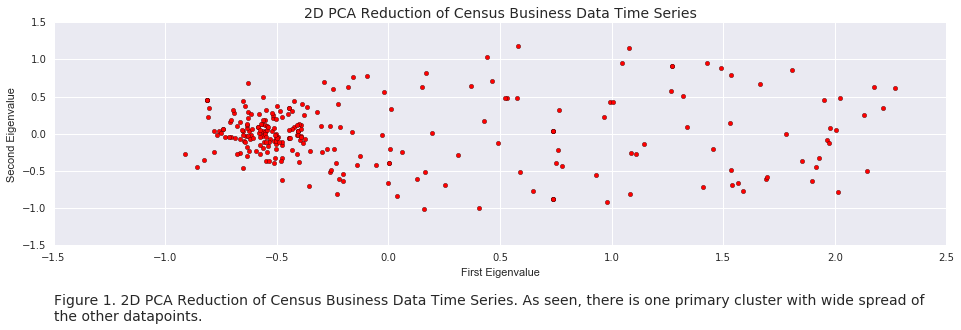

In [351]:
n=2
pca = PCA(n)
Xproj = pca.fit_transform(zipnormt)
Xproj_df = pd.DataFrame(Xproj)
eigenvalues = pca.explained_variance_

fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.scatter(Xproj[:, 0], Xproj[:, 1], c='r')
ax.set_xlabel('First Eigenvalue')
ax.set_ylabel('Second Eigenvalue')
ax.set_title('2D PCA Reduction of Census Business Data Time Series', fontsize=14)
ax.text(-1.5, -2.5, 
        'Figure 1. 2D PCA Reduction of Census Business Data Time Series. ' + \
        'As seen, there is one primary cluster with wide spread of \nthe other datapoints.', 
        fontsize = 14)

#### Calculate Silhouette Score

In [321]:
X = zipnormt
range_n_clusters = range(2, 10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}".format(n_clusters) +
          " the average silhouette_score is :{}".format(silhouette_avg.round(3)))

For n_clusters = 2 the average silhouette_score is :0.536
For n_clusters = 3 the average silhouette_score is :0.498
For n_clusters = 4 the average silhouette_score is :0.392
For n_clusters = 5 the average silhouette_score is :0.262
For n_clusters = 6 the average silhouette_score is :0.261
For n_clusters = 7 the average silhouette_score is :0.148
For n_clusters = 8 the average silhouette_score is :0.172
For n_clusters = 9 the average silhouette_score is :0.155


#### K-means clustering with 4 clusters

(165, 4)
(94, 4)


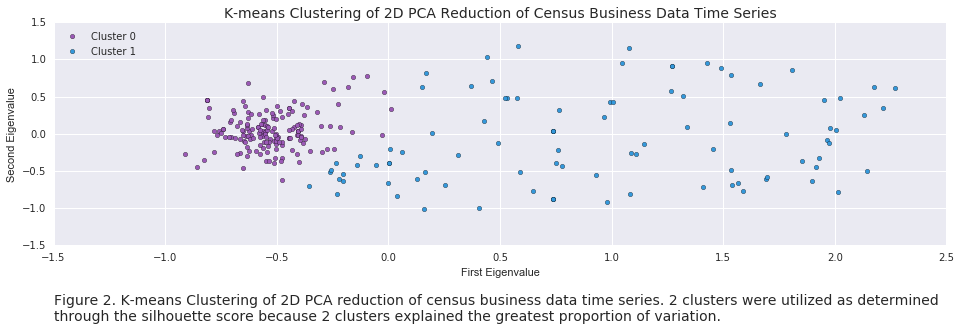

In [445]:
# Run the KMeans model and append cluster labels to data1
km = KMeans(n_clusters=2, random_state=324)
Xproj_df['cluster'] = km.fit_predict(X)
zipnormt['cluster'] = km.fit_predict(X)
zipd['cluster'] = km.fit_predict(X)

# Group Xproj_df by cluster label to plot with labels.
groups = Xproj_df.groupby('cluster')

# Plot by groups
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16,4))
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e"]
for name, group in groups:
    print group.shape
    label = 'Cluster ' + str(name)
    ax.scatter(group[0], group[1], label=label, c=colors[name])
ax.set_xlabel('First Eigenvalue')
ax.set_ylabel('Second Eigenvalue')
ax.set_title('K-means Clustering of 2D PCA Reduction of Census Business Data Time Series', fontsize = 14)
ax.text(-1.5, -2.5, 
        'Figure 2. K-means Clustering of 2D PCA reduction of census business data time series. ' + \
        '2 clusters were utilized as determined \nthrough the silhouette score because ' + \
        '2 clusters explained the greatest proportion of variation.', 
        fontsize = 14)
ax.legend(loc='upper left')

### Clustering (Other, DBSCAN)

(112, 4)
(147, 4)


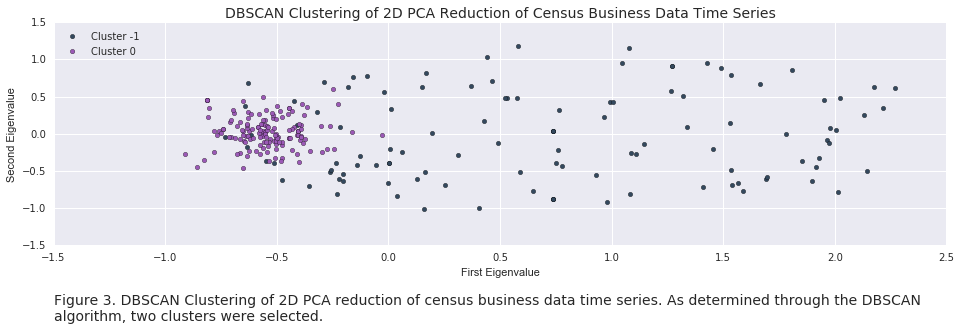

In [431]:
db = DBSCAN(eps=0.5, min_samples=20).fit(X)
Xproj_df['cluster1'] = db.fit_predict(X)
zipnormt['cluster1'] = db.fit_predict(X)
zipd['cluster1'] = db.fit_predict(X)

# Group Xproj_df by cluster label to plot with labels.
groups = Xproj_df.groupby('cluster1')

# Plot by groups
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16,4))
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e"]
for name, group in groups:
    print group.shape
    label = 'Cluster ' + str(name)
    ax.scatter(group[0], group[1], label=label, c=colors[name])
ax.set_xlabel('First Eigenvalue')
ax.set_ylabel('Second Eigenvalue')
ax.set_title('DBSCAN Clustering of 2D PCA Reduction of Census Business Data Time Series', fontsize = 14)
ax.text(-1.5, -2.5, 
        'Figure 3. DBSCAN Clustering of 2D PCA reduction of census business data time series. ' + \
        'As determined through the DBSCAN \nalgorithm, two clusters were selected.', 
        fontsize = 14)
ax.legend(loc='upper left')

### Plot over NYC & Comparison

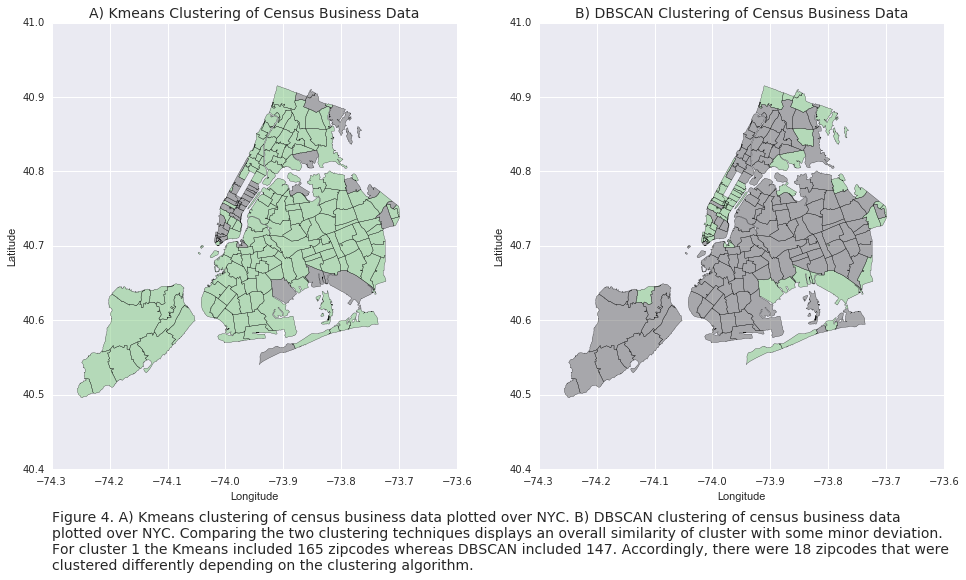

In [434]:
geo_df = gpd.GeoDataFrame(zipd, geometry=zipd.geometry)

fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16,8))
geo_df.plot(column='cluster', ax=ax1, cmap='Accent', linewidth=0.25)
ax1.set_title('A) Kmeans Clustering of Census Business Data', fontsize=14)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

geo_df.plot(column='cluster1', ax=ax2, cmap='Accent', linewidth=0.25)
ax2.set_title('B) DBSCAN Clustering of Census Business Data', fontsize=14)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

fig.text(0.125, -0.05, 'Figure 4. A) Kmeans clustering of census business data plotted ' + \
         'over NYC. B) DBSCAN clustering of census business data \nplotted over NYC. ' + \
         'Comparing the two clustering techniques displays an overall similarity of ' + \
         'cluster with some minor deviation. \nFor cluster 1 the Kmeans included 165 ' + \
         'zipcodes whereas DBSCAN included 147. Accordingly, there were 18 zipcodes ' + \
         'that were \nclustered differently depending on the clustering algorithm.', fontsize=14)

### Interpretation

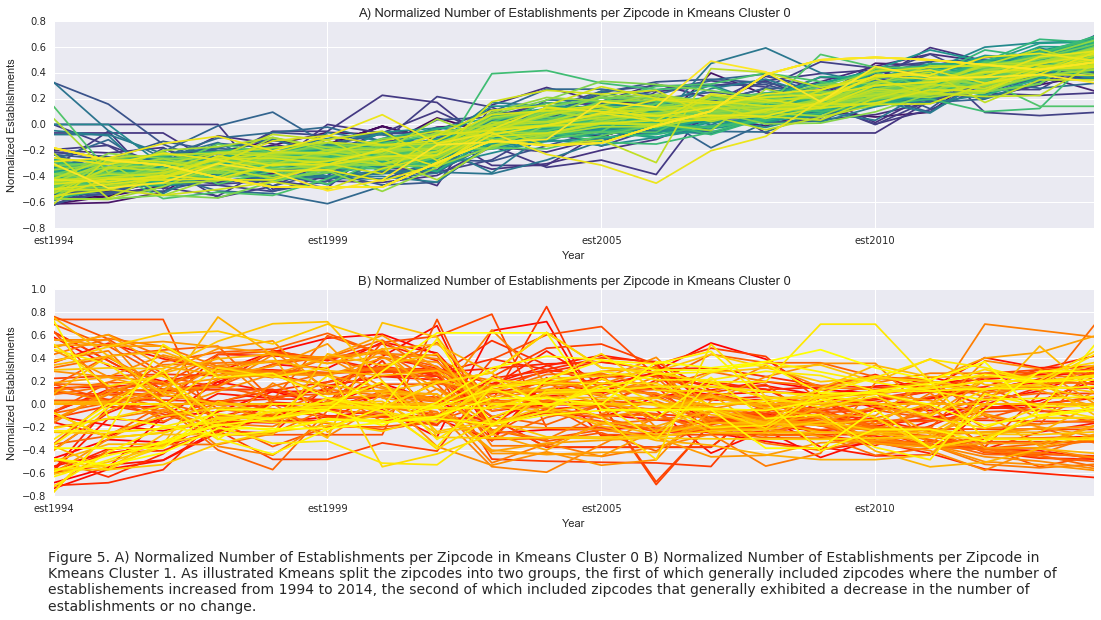

In [509]:
fig, (ax1, ax2) = pl.subplots(nrows=2, ncols=1, figsize=(16,8))
pl.tight_layout(pad=4)

zipnormt[zipnormt.cluster == 0].T.drop(['cluster', 'cluster1']).plot(ax=ax1, legend=False, cmap='viridis')
ax1.set_title('A) Normalized Number of Establishments per Zipcode in Kmeans Cluster 0', fontsize=13)
ax1.set_xlabel('Year')
ax1.set_ylabel('Normalized Establishments')

zipnormt[zipnormt.cluster != 0].T.drop(['cluster', 'cluster1']).plot(ax=ax2, legend=False, cmap='autumn')
ax2.set_title('B) Normalized Number of Establishments per Zipcode in Kmeans Cluster 0', fontsize=13)
ax2.set_xlabel('Year')
ax2.set_ylabel('Normalized Establishments')

fig.text(0.05, -0.1, 'Figure 5. A) Normalized Number of Establishments per Zipcode ' + \
         'in Kmeans Cluster 0 B) Normalized Number of Establishments per Zipcode in ' + \
         '\nKmeans Cluster 1. As illustrated Kmeans split the zipcodes into two groups, ' + \
         'the first of which generally included zipcodes where the number of ' + \
         '\nestablishements increased from 1994 to 2014, the second of which included ' + \
         'zipcodes that generally exhibited a decrease in the number of \nestablishments ' + \
         'or no change.', fontsize=14)